# FPL Draft Picks

The FPL Draft runs alongside the Fantasy Premier League and uses the same player scoring system. However, the player-selection system varies:

There are no player prices and no budgets, with managers using a draft system to build their squads. In the draft, each manager takes their turn to select players over 15 rounds (2 goalkeepers, 5 defenders, 5 midfielders, and 3 forwards). The order of picks is decided randomly at first and will then “snake” from round to round, with the pick order reversed each time

*[Full rules here](https://draft.premierleague.com/help)*


## Draft Selection Model
In this notebook I created a model that aims to optimize the draft player-selection process by ranking the best player picks per draft round. In other words, for every draft round, the algorithm ranks 10 players per round (for a 10-manager league), based on statistics from the 21-22 season (discussed later).

## Index
* [Data Cleaning](#data-cleaning)
* [Best Player Picks - Points Per 90min](#PP90min)
* [Best Player Picks - Total Points](#total-points)
* [Best Player Picks - Injured/Rotating/Transferred Players](#injured)
* [Ideal Team - Points Per 90min](#PP90min-team)
* [Ideal Team - Total Points](#total-points-team)
* [Ideal Team - Injured/Rotating/Transferred Players](#injured-team)
* [Model Limitations](#limitations)

In [1]:
#Import libraries and packages
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import sys
from pathlib import Path
from IPython.display import FileLink, FileLinks

/Users/amirgrunhaus/opt/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Path to data directory
path = Path('./Data')

#Import dataset
data = pd.read_csv(path/'training_data.csv', 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

## Data Cleaning <a class="anchor" id="data-cleaning"></a>

The original data has one row per player, per gameweek, for each player and gameweek since the 2016-2017 season; however, I only use the data from the 21-22 season.

First, I group the data by player and get the total points scored by each player during the season, and the total minutes played by each player.

Then, I calculate how many points each player scored per each match played (points scored per 90min - pp90min), and drop players that played less than half of the season's games. The reasons I do this are:

- To drop misleading data points. For example, let's assume a player plays one game, scores 8 points, and then never plays a game again (due to injury, rotation, transfer, etc.) The player will have a high value for pp90min, which, although true, might mislead the model's selections as we do not want to select a player that just played one game.
- Because players who played very few games are arguably not good player picks. We want players that play games regularly.

*Note: Later in the notebook I create a dataframe specifically for players that played very few games (injured/rotating/transferred players)*

Finally, I update the position for player's that have a different position in this year's FPL. 

The final dataframe has one row for every player that played at least half of the games during the season, the total points scored, the total minutes played, points per 90 minutes played, the player's position, and the player's team.

In [3]:
#Select Data from Last Season
data_2122 = data[data['season'] == '2122']
data_2122.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24710 entries, 114801 to 139510
Data columns (total 59 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   player                                      24710 non-null  object 
 1   gw                                          24710 non-null  int64  
 2   position                                    24710 non-null  int64  
 3   minutes                                     24710 non-null  int64  
 4   team                                        24710 non-null  object 
 5   opponent_team                               24710 non-null  object 
 6   relative_market_value_team                  12750 non-null  float64
 7   relative_market_value_opponent_team         12750 non-null  float64
 8   was_home                                    24710 non-null  bool   
 9   total_points                                24710 non-null  int64  
 10  assi

In [4]:
#Get total points per player, and total minutes per player
points_per_player = data_2122.groupby(['player']).sum()['total_points'].sort_values(ascending=False)
minutes_per_player = data_2122.groupby(['player']).sum()['minutes'].sort_values(ascending=False)

#New Dataframe with stats above and points per 90minutes played
draft_selection_stats = pd.merge(points_per_player, minutes_per_player, on = 'player')
draft_selection_stats['points_per_90_minutes_played'] = draft_selection_stats['total_points']/(draft_selection_stats['minutes']/90)

#Dropping players that played less than half of the games
draft_selection_stats = draft_selection_stats[draft_selection_stats['minutes'] >= (38/2)*90]
draft_selection_stats = draft_selection_stats.sort_values('points_per_90_minutes_played', ascending=False)
draft_selection_stats = draft_selection_stats.merge(data_2122[['player','position','team']], on = 'player').drop_duplicates()

def position_assignment(data):
    if data['position'] == 4:
        return 'FWD'
    if data['position'] == 3:
        return 'MID'
    if data['position'] == 2:
        return 'DEF'
    if data['position'] == 1:
        return 'GKP'

draft_selection_stats['position'] = draft_selection_stats.apply(position_assignment, axis = 1)

#Drop relegated teams
draft_selection_stats = draft_selection_stats[draft_selection_stats['team'] != 'Norwich']
draft_selection_stats = draft_selection_stats[draft_selection_stats['team'] != 'Burnley']
draft_selection_stats = draft_selection_stats[draft_selection_stats['team'] != 'Watford']

#Update 22-23 Player Position Changes and Drop Transferred out Players
draft_selection_stats = draft_selection_stats.set_index('player')
draft_selection_stats.at['Diogo Jota','position']= 'FWD'
draft_selection_stats.at['Allan Saint-Maximin','position']= 'MID'
draft_selection_stats.at['Stuart Dallas','position']= 'DEF'
draft_selection_stats.at['Kai Havertz','position']= 'FWD'
draft_selection_stats.at['Bryan Mbeumo','position']= 'FWD'
draft_selection_stats = draft_selection_stats.reset_index()
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Sadio Mané']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Alexandre Lacazette']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Antonio Rüdiger']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Andreas Christensen']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Romelu Lukaku']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Divock Origi']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Edinson Cavani']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Paul Pogba']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Steven Bergwijn']
draft_selection_stats = draft_selection_stats[draft_selection_stats['player'] != 'Romain Saïss']


#Drop duplicates, make rows a multiple of 10 (for draft picks), reset index
draft_selection_stats = draft_selection_stats.drop_duplicates('player')
draft_selection_stats = draft_selection_stats.iloc[:-7]
draft_selection_stats

,player,total_points,minutes,points_per_90_minutes_played,position,team
0,Mohamed Salah,259,2726,8.550990,MID,Liverpool
1,Kevin De Bruyne,190,2106,8.119658,MID,Manchester City
2,Heung-Min Son,246,2919,7.584789,MID,Tottenham Hotspur
3,Raheem Sterling,159,2087,6.856732,MID,Manchester City
4,Diogo Jota,174,2300,6.808696,FWD,Liverpool
...,...,...,...,...,...,...
175,Moussa Sissoko,83,3130,2.386581,MID,Tottenham Hotspur
176,Çaglar Söyüncü,66,2497,2.378855,DEF,Leicester City
177,Luke Thomas,50,1911,2.354788,DEF,Leicester City
178,Granit Xhaka,58,2265,2.304636,MID,Arsenal


## Best Player Picks - Points per 90min <a class="anchor" id="pp90min"></a>

The following algorithm ranks the best 10 picks for each draft round according to **points scored per 90min**. Each column is a draft round, and each row is a rank (from 1-10, for each of the 10 picks per round). 

*Why Points per 90min?* 
- The points-per-game (90min) statistic has the advantage of factoring in the breadth of scenarios in which the player is effective. In other words, it tells us how often a player succeeds in scoring points, which is what we care for when selecting players for our team. That is why pp90min is a reliable statistic to base our player selections on.

**I included 2 extra rounds (17 rounds in total)*

In [5]:
#Best picks per round according to Points Scored per 90min
draft_picks_points_per_90 = pd.DataFrame(draft_selection_stats.player.values.reshape(-1, 10))
draft_picks_points_per_90 = draft_picks_points_per_90.transpose()
draft_picks_points_per_90.index += 1

column_names = []
for n in range(1, 18):
    column_names.append("Round " + str(n))

draft_picks_points_per_90.columns = column_names

#Convert table to csv file
draft_picks_points_per_90.to_csv('./draft_picks_points_per_90.csv', index=False)
draft_picks_points_per_90

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17
1,Mohamed Salah,James Maddison,Joel Matip,Gabriel Teodoro Martinelli Silva,Bruno Miguel Borges Fernandes,Jeffrey Schlupp,David Raya Martin,Neal Maupay,Pablo Fornals,Martin Dubravka,Max Kilman,Marc Guéhi,Daniel James,Cristian Romero,Douglas Luiz Soares de Paulo,Yves Bissouma,Victor Lindelöf
2,Kevin De Bruyne,Jarrod Bowen,Ilkay Gündogan,Kieran Tierney,Richarlison de Andrade,Armando Broja,Hee-Chan Hwang,Ollie Watkins,Eric Dier,Raphaël Varane,Alex Iwobi,Tyrone Mings,Tino Livramento,Pierre-Emile Højbjerg,Christian Nørgaard,Joël Veltman,Joel Ward
3,Heung-Min Son,Phil Foden,Bukayo Saka,Alisson Ramses Becker,Rayan Ait Nouri,Jorge Luiz Frello Filho,Jack Grealish,Anthony Gordon,Rodrigo Hernandez,Fabian Schär,Rico Henry,Tomas Soucek,Lewis Dunk,Liam Cooper,Kiernan Dewsbury-Hall,Oriol Romeu Vidal,Harry Maguire
4,Raheem Sterling,Gabriel Fernando de Jesus,Virgil van Dijk,Bernardo Mota Veiga de Carvalho e Silva,Ivan Toney,Frederico Rodrigues de Paula Santos,Alexis Mac Allister,Emerson Aparecido Leite de Souza Junior,Kristoffer Ajer,Joachim Andersen,David de Gea,Dan Burn,Rúben Diogo da Silva Neves,Chris Wood,Kurt Zouma,Illan Meslier,Stuart Dallas
5,Diogo Jota,Emile Smith Rowe,Marcos Alonso,Sergio Reguilón,James Ward-Prowse,Youri Tielemans,Jacob Ramsey,Aaron Cresswell,Jack Harrison,Allan Saint-Maximin,Cheikhou Kouyaté,Sergi Canós,John McGinn,Lucas Digne,João Filipe Iria Santos Moutinho,José Diogo Dalot Teixeira,Allan Marques Loureiro
6,Reece James,Harvey Barnes,Rúben Santos Gato Alves Dias,Wilfried Zaha,Kyle Walker,Gabriel Magalhães,Aaron Ramsdale,Jordan Henderson,Fabio Henrique Tavares,Ben Davies,Joseph Willock,Raúl Jiménez,Jan Bednarek,Timothy Castagne,Vladimir Coufal,Mason Holgate,Moussa Sissoko
7,Trent Alexander-Arnold,Cristiano Ronaldo dos Santos Aveiro,Emiliano Buendía Stati,Che Adams,Raphael Dias Belloli,Demarai Gray,José Malheiro de Sá,Edouard Mendy,Conor Coady,Vitaly Janelt,Pascal Groß,Michael Keane,Abdoulaye Doucouré,Craig Dawson,Kyle Walker-Peters,Declan Rice,Çaglar Söyüncü
8,Mason Mount,Saïd Benrahma,Aymeric Laporte,Leandro Trossard,Jadon Sancho,Michail Antonio,Mohamed Elyounoussi,César Azpilicueta,Bryan Mbeumo,Leander Dendoncker,Robert Sánchez,Pontus Jansson,Matt Targett,Ethan Pinnock,Joelinton Cássio Apolinário de Lira,Seamus Coleman,Luke Thomas
9,Andrew Robertson,João Pedro Cavaco Cancelo,Harry Kane,Thiago Emiliano da Silva,Lucas Rodrigues Moura da Silva,Martin Ødegaard,Nathan Redmond,Matthew Cash,Lukasz Fabianski,Kasper Schmeichel,Jordan Ayew,Ben White,Thomas Partey,Fraser Forster,Jonjo Shelvey,Mateusz Klich,Granit Xhaka
10,Jamie Vardy,Kai Havertz,Danny Ings,Conor Gallagher,Ederson Santana de Moraes,Hugo Lloris,Nélson Cabral Semedo,Vicente Guaita,Marc Cucurella,Emiliano Martínez,Rodrigo Moreno,Jordan Pickford,Tyrick Mitchell,Diego Llorente,Ezri Konsa Ngoyo,Scott McTominay,Daniel Amartey


### Top 50 Players (pp90min) per Team - Data Visualization

In [18]:
#Pie chart that shows the percentage of top 50 players (according to points per 90min played) per team
top_50_players_pp90min = draft_selection_stats.head(50)
team_prop_pp90min = top_50_players_pp90min.groupby('team').count().reset_index()
fig1 = px.pie(team_prop_pp90min, values='player', names='team', title='Top 50 Players (pp90min) Per Team')
fig1

### Top 50 Players (pp90min) per Position - Data Visualization

In [19]:
#Pie chart that shows the percentage of top 50 players (according to points per 90min played) per position
top_50_players_pp90min = draft_selection_stats.head(50)
position_prop_pp90min = top_50_players_pp90min.groupby('position').count().reset_index()
fig2 = px.pie(position_prop_pp90min, values='player', names='position', title='Top 50 Players (pp90min) Per Position')
fig2

## Best Player Picks - Total Points <a class="anchor" id="total-points"></a>

The following algorithm ranks the best 10 picks for each draft round according to **total points scored**. Each column is a draft round, and each row is a rank (from 1-10, for each of the 10 picks per round). 

*Why Total Points?* 
- Total Points (during the season) is arguably the best measure of player effectiveness and success. If we assume last season's performance will be indicative of this season's performance, then Total Points is possibly the best measure to base our player selections on, as we want the players who score the highest points in our team.

**I included 2 extra rounds (17 rounds in total)*

In [8]:
#Best picks per round according to Total Points Scored
draft_picks_total_points = draft_selection_stats.sort_values('total_points', ascending=False)
draft_picks_total_points = pd.DataFrame(draft_picks_total_points.player.values.reshape(-1, 10))
draft_picks_total_points = draft_picks_total_points.transpose()
draft_picks_total_points.index += 1

column_names = []
for n in range(1, 18):
    column_names.append("Round " + str(n))

draft_picks_total_points.columns = column_names

#Convert table to csv file
draft_picks_total_points.to_csv('./draft_picks_total_points.csv', index=False)
draft_picks_total_points

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17
1,Mohamed Salah,Bukayo Saka,James Ward-Prowse,Gabriel Magalhães,David de Gea,Robert Sánchez,Bryan Mbeumo,John McGinn,Emiliano Buendía Stati,Ben Davies,David Raya Martin,Chris Wood,Oriol Romeu Vidal,Joelinton Cássio Apolinário de Lira,Nathan Redmond,Vladimir Coufal,Cristian Romero
2,Heung-Min Son,Alisson Ramses Becker,Hugo Lloris,Conor Gallagher,Kasper Schmeichel,Marc Cucurella,Jordan Pickford,Jack Harrison,Kai Havertz,Neal Maupay,Declan Rice,Lewis Dunk,Jack Grealish,Kristoffer Ajer,Jordan Ayew,Kiernan Dewsbury-Hall,Mason Holgate
3,Trent Alexander-Arnold,James Maddison,Bruno Miguel Borges Fernandes,Conor Coady,Emiliano Martínez,Jamie Vardy,Pablo Fornals,Jacob Ramsey,Demarai Gray,Gabriel Teodoro Martinelli Silva,Martin Dubravka,Dan Burn,Rayan Ait Nouri,Tino Livramento,Alex Iwobi,Joel Ward,Mateusz Klich
4,Jarrod Bowen,Mason Mount,José Malheiro de Sá,Raphael Dias Belloli,Edouard Mendy,Marc Guéhi,Joachim Andersen,Ben White,Sergio Reguilón,Matt Targett,Rúben Diogo da Silva Neves,Craig Dawson,Kyle Walker,Stuart Dallas,Cheikhou Kouyaté,Harry Maguire,Granit Xhaka
5,João Pedro Cavaco Cancelo,Joel Matip,Rúben Santos Gato Alves Dias,Phil Foden,Marcos Alonso,Martin Ødegaard,Aaron Cresswell,Max Kilman,Tyrick Mitchell,Fabio Henrique Tavares,Armando Broja,Abdoulaye Doucouré,César Azpilicueta,Lucas Digne,Pascal Groß,Çaglar Söyüncü,Liam Cooper
6,Kevin De Bruyne,Cristiano Ronaldo dos Santos Aveiro,Leandro Trossard,Reece James,Thiago Emiliano da Silva,Pontus Jansson,Tomas Soucek,Jorge Luiz Frello Filho,Illan Meslier,Emerson Aparecido Leite de Souza Junior,Daniel James,Fabian Schär,Jeffrey Schlupp,Joseph Willock,Raphaël Varane,Scott McTominay,Allan Marques Loureiro
7,Virgil van Dijk,Raheem Sterling,Wilfried Zaha,Lukasz Fabianski,Ollie Watkins,Gabriel Fernando de Jesus,Allan Saint-Maximin,Kieran Tierney,Che Adams,Raúl Jiménez,Alexis Mac Allister,Vitaly Janelt,Moussa Sissoko,Seamus Coleman,Diego Llorente,Yves Bissouma,Fraser Forster
8,Harry Kane,Aymeric Laporte,Matthew Cash,Aaron Ramsdale,Eric Dier,Youri Tielemans,Ilkay Gündogan,Pierre-Emile Højbjerg,Michael Keane,Nélson Cabral Semedo,Jadon Sancho,Mohamed Elyounoussi,Lucas Rodrigues Moura da Silva,Hee-Chan Hwang,Leander Dendoncker,Kurt Zouma,Daniel Amartey
9,Andrew Robertson,Ederson Santana de Moraes,Ivan Toney,Michail Antonio,Emile Smith Rowe,Rodrigo Hernandez,Vicente Guaita,Rico Henry,Christian Nørgaard,Jan Bednarek,Frederico Rodrigues de Paula Santos,Douglas Luiz Soares de Paulo,Rodrigo Moreno,Sergi Canós,Thomas Partey,Victor Lindelöf,José Diogo Dalot Teixeira
10,Diogo Jota,Bernardo Mota Veiga de Carvalho e Silva,Saïd Benrahma,Harvey Barnes,Richarlison de Andrade,Tyrone Mings,Jordan Henderson,Danny Ings,Anthony Gordon,João Filipe Iria Santos Moutinho,Ethan Pinnock,Joël Veltman,Kyle Walker-Peters,Ezri Konsa Ngoyo,Timothy Castagne,Jonjo Shelvey,Luke Thomas


### Top 50 Players (Total Points) per Team - Data Visualization

In [20]:
#Pie chart that shows the percentage of top 50 players (according to total points) per team
top_50_players_total_points = draft_selection_stats.sort_values('total_points', ascending=False).head(50)
team_prop_total_points = top_50_players_total_points.groupby('team').count().reset_index()
fig3 = px.pie(team_prop_total_points, values='player', names='team', title='Top 50 Players (Total Points) Per Team')
fig3

### Top 50 Players (Total Points) per Position - Data Visualization

In [21]:
#Pie chart that shows the percentage of top 50 players (according to total points) per position
top_50_players_total_points = draft_selection_stats.sort_values('total_points', ascending=False).head(50)
position_prop_total_points = top_50_players_total_points.groupby('position').count().reset_index()
fig4 = px.pie(position_prop_total_points, values='player', names='position', title='Top 50 Players (Total Points) Per Position')
fig4

## Best Player Picks - Injured/Rotating/Transferred Players <a class="anchor" id="injured"></a>

Players that play very few games are *usually* not good player picks, however, if a player didn't play more than half of the games last season, that does not necessarily mean that they won't be a good player pick for this season. 

The following dataframe has the same data as the first dataframe, but this time, for players that played between 1/4th and half of all gameweeks. Players that fulfill this condition might still be potentially good selections (although they didn't play a lot of games), for a number of reasons:

- **Injury**: The player was injured for more than half of last season. However, if they have a high pp90min value, we can assume that if they had not been injured and had played more games they would've maintained a high pp90min value.
- **Rotation**: The player was highly rotated (was in the bench or started from the bench many games), but each time they played had a high pp90min value. 
- **Transfer**: The player was transferred-in during the Winter Transfer Market (halfway through the season), and didn't have a chance to play more than half of games.

Let me give you an example for each of these cases:
- **Injured Player**: Ryan Fraser, Newcastle. Fraser was injured last season for 63 days. He played around 16 games (less than half of games), however, he had a pp90min value of 4.81, which is relatively high compared to the 3.69 median.
- **Highly Rotated Player**: Riyadh Mahrez, Man City. Mahrez started a lot of games from the bench, playing a total of 1430 minutes (around 16 games) - less than half of the total season minutes. However, he had a pp90min value of 8.43, one of the highest in the league. 
- **Transferred-In Player**: Dejan Kulusevski, Tottenham. Kulusevski was transferred in from Juventus during the Winter Transfer Market. He played around 13 games (less than half of games), but had a pp90min value of 6.27.

While this season's player picks should ideally be based on the algorithms above (total points and pp90min for players who played more than half the season), this algorithm serves as a *'Plan B'* and gives us a list of players that could be good selections if their playing prospects for this season improve, or in other words, if we expect them to play more minutes this season than last season.

*Why don't we want players who played less than 1/4th of the season's total minutes?*
- As mentioned above, we do not want to select players who played very few games last season, and 1/4th of games (around 9 games), looks like a good cutoff. If the player was injured for most of the season, we can argue that last season's performance will not be indicative of this season's performance. Moreover, if a player was not injured but was benched during most of last season's games, we can assume that they won't play a lot of games this season, which makes them a bad player selection for this season. 

**This algorithm gives us a table with less than 15 rounds (there are less than 15x10 = 150 players who played between 1/4th and half of all games)*

In [11]:
#Get total points per player, and total minutes per player
points_per_player = data_2122.groupby(['player']).sum()['total_points'].sort_values(ascending=False)
minutes_per_player = data_2122.groupby(['player']).sum()['minutes'].sort_values(ascending=False)

#New Dataframe with stats above and points per 90minutes played
#for players who played between 1/4th and half of gameweeks (assuming they were injured during the season, 
#transferred in, or highly rotated)
draft_selection_stats_injured = pd.merge(points_per_player, minutes_per_player, on = 'player')
draft_selection_stats_injured['points_per_90_minutes_played'] = draft_selection_stats_injured['total_points']/(draft_selection_stats_injured['minutes']/90)
draft_selection_stats_injured = draft_selection_stats_injured.loc[(draft_selection_stats_injured['minutes'] >= (38/4)*90) 
                                                              & (draft_selection_stats_injured['minutes'] <= (38/2)*90)]

draft_selection_stats_injured = draft_selection_stats_injured.sort_values('total_points', ascending=False)
draft_selection_stats_injured = draft_selection_stats_injured.merge(data_2122[['player','position','team']], on = 'player').drop_duplicates()

#Convert position from int to string
def position_assignment(data):
    if data['position'] == 4:
        return 'FWD'
    if data['position'] == 3:
        return 'MID'
    if data['position'] == 2:
        return 'DEF'
    if data['position'] == 1:
        return 'GKP'

draft_selection_stats_injured['position'] = draft_selection_stats_injured.apply(position_assignment, axis = 1)

#Drop relegated teams
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['team'] != 'Norwich']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['team'] != 'Burnley']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['team'] != 'Watford']

# #Update 22-23 Player Position Changes and Drop Transferred out Players
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Andreas Christensen']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Romelu Lukaku']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Paul Pogba']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Fernando Marçal']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Francisco Machado Mota de Castro Trincão']
draft_selection_stats_injured = draft_selection_stats_injured[draft_selection_stats_injured['player'] != 'Alex Nicolao Telles']


#Drop duplicates (players transferred to other teams during season), make rows a multiple of 10 (for draft picks), reset index
draft_selection_stats_injured = draft_selection_stats_injured.drop_duplicates('player')
draft_selection_stats_injured = draft_selection_stats_injured.iloc[:-5]
draft_selection_stats_injured = draft_selection_stats_injured.reset_index().drop('index', axis=1)
draft_selection_stats_injured

,player,total_points,minutes,points_per_90_minutes_played,position,team
0,Riyad Mahrez,134,1430,8.433566,MID,Manchester City
1,Trevoh Chalobah,99,1447,6.157567,DEF,Chelsea
2,Manuel Lanzini,90,1697,4.773129,MID,West Ham United
3,Davinson Sánchez,87,1536,5.097656,DEF,Tottenham Hotspur
4,Yoane Wissa,86,1178,6.570458,MID,Brentford
...,...,...,...,...,...,...
95,Issa Diop,30,961,2.809573,DEF,West Ham United
96,Isaac Hayden,28,1000,2.520000,MID,Newcastle United
97,James Justin,27,906,2.682119,DEF,Leicester City
98,Nampalys Mendy,22,942,2.101911,MID,Leicester City


In [12]:
#Best picks per round according to Total Points Scored (for injured players)
draft_picks_total_points_injured = pd.DataFrame(draft_selection_stats_injured.player.values.reshape(-1, 10))
draft_picks_total_points_injured = draft_picks_total_points_injured.transpose()
draft_picks_total_points_injured.index += 1

column_names = []
for n in range(1, 11):
    column_names.append("Round " + str(n))

draft_picks_total_points_injured.columns = column_names

#Convert table to csv file
draft_picks_total_points_injured.to_csv('./draft_picks_total_points_injured.csv', index=False)
draft_picks_total_points_injured

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10
1,Riyad Mahrez,N'Golo Kanté,Daniel Castelo Podence,Timo Werner,Adam Webster,Mathias Jensen,Ben Johnson,Mads Roerslev Rasmussen,Jonny Evans,Harry Winks
2,Trevoh Chalobah,Christian Pulisic,Patson Daka,Luis Díaz,Enock Mwepu,Nemanja Matic,Sean Longstaff,Wilfred Ndidi,Jonathan Castro Otto,Álvaro Fernández
3,Manuel Lanzini,Hakim Ziyech,John Stones,Jean-Philippe Mateta,Miguel Almirón,Nathaniel Clyne,Luke Shaw,Calum Chambers,Boubakary Soumaré,Ricardo Domingos Barbosa Pereira
4,Davinson Sánchez,Mateo Kovacic,Matt Doherty,Jacob Murphy,Fraser Forster,Stuart Armstrong,Ibrahima Diallo,Rodrigo Bentancur,Frank Onyeka,Ibrahima Konaté
5,Yoane Wissa,Takehiro Tomiyasu,Andros Townsend,Dominic Calvert-Lewin,Solomon March,Ruben Loftus-Cheek,Adama Traoré,Marc Albrighton,Tyler Roberts,Albert Sambi Lokonga
6,Odsonne Edouard,Philippe Coutinho Correia,Bruno Guimarães Rodriguez Moura,Emil Krafth,Alex McCarthy,Ryan Sessegnon,Adam Lallana,Angelo Ogbonna,Cédric Soares,Issa Diop
7,Dejan Kulusevski,Ademola Lookman,Thiago Alcántara do Nascimento,Roberto Firmino,Adam Armstrong,Ashley Young,Pierre-Emerick Aubameyang,Javier Manquillo,Oliver Skipp,Isaac Hayden
8,Kelechi Iheanacho,Tariq Lamptey,Naby Keita,Jakub Moder,Oleksandr Zinchenko,Callum Hudson-Odoi,Fernando Luiz Rosa,Adam Forshaw,Shandon Baptiste,James Justin
9,Ryan Fraser,Michael Olise,Marcus Rashford,Christian Benteke,Nathan Aké,Shane Duffy,Konstantinos Tsimikas,Romain Perraud,Bamidele Alli,Nampalys Mendy
10,Danny Welbeck,Mason Greenwood,Callum Wilson,Anthony Elanga,James McArthur,Nuno Varela Tavares,Vitalii Mykolenko,Kalvin Phillips,Will Hughes,Marvelous Nakamba


### Top 50 Injured/Rotating/Transferred Players (pp90min) per Team - Data Visualization

In [22]:
#Pie chart that shows the percentage of top 50 (according to pp90min) per team
top_50_players_injured_pp90min = draft_selection_stats_injured.sort_values('points_per_90_minutes_played', ascending=False).head(50)
team_prop_pp90min_injured = top_50_players_injured_pp90min.groupby('team').count().reset_index()
fig5 = px.pie(team_prop_pp90min_injured, values='player', names='team', title='Top 50 Injured/Rotating/Transferred Players (pp90min) Per Team')
fig5

### Top 50 Injured/Rotating/Transferred Players (pp90min) per Position - Data Visualization

In [23]:
#Pie chart that shows the percentage of top 50 players (according to pp90min) per position
position_prop_pp90min_injured = top_50_players_injured_pp90min.groupby('position').count().reset_index()
fig6 = px.pie(position_prop_pp90min_injured, values='player', names='position', title='Top 50 Injured/Rotating/Transferred Players (pp90min) Per Position')
fig6

## Ideal Team - Points Per 90min <a class="anchor" id="PP90min-team"></a>

The algorithm below gives us an ideal team (the best player picks), according to **Points Scored per 90min**. The team fulfills the position requirements (2 goalkeepers, 5 defenders, 5 midfielders, and 3 forwards). 

If we were to freely pick players based on PP90min (assuming no other manager picks any of these players - which is very unlikely), we should pick this team's players.

In [15]:
#Best Overall Team (PP90min)
goalkeepers = []
defenders = []
midfielders = []
forwards = []
for index, row in draft_selection_stats.iterrows():
    if row['position'] == 'GKP' and len(goalkeepers) < 2:
        goalkeepers.append(row['player'])
    elif row['position'] == 'DEF' and len(defenders) < 5:
        defenders.append(row['player'])
    elif row['position'] == 'MID' and len(midfielders) < 5:
        midfielders.append(row['player'])
    elif row['position'] == 'FWD' and len(forwards) < 3:
        forwards.append(row['player'])

print(goalkeepers)
print(defenders)
print(midfielders)
print(forwards)

['Alisson Ramses Becker', 'Ederson Santana de Moraes']
['Reece James', 'Trent Alexander-Arnold', 'Andrew Robertson', 'João Pedro Cavaco Cancelo', 'Joel Matip']
['Mohamed Salah', 'Kevin De Bruyne', 'Heung-Min Son', 'Raheem Sterling', 'Mason Mount']
['Diogo Jota', 'Jamie Vardy', 'Gabriel Fernando de Jesus']


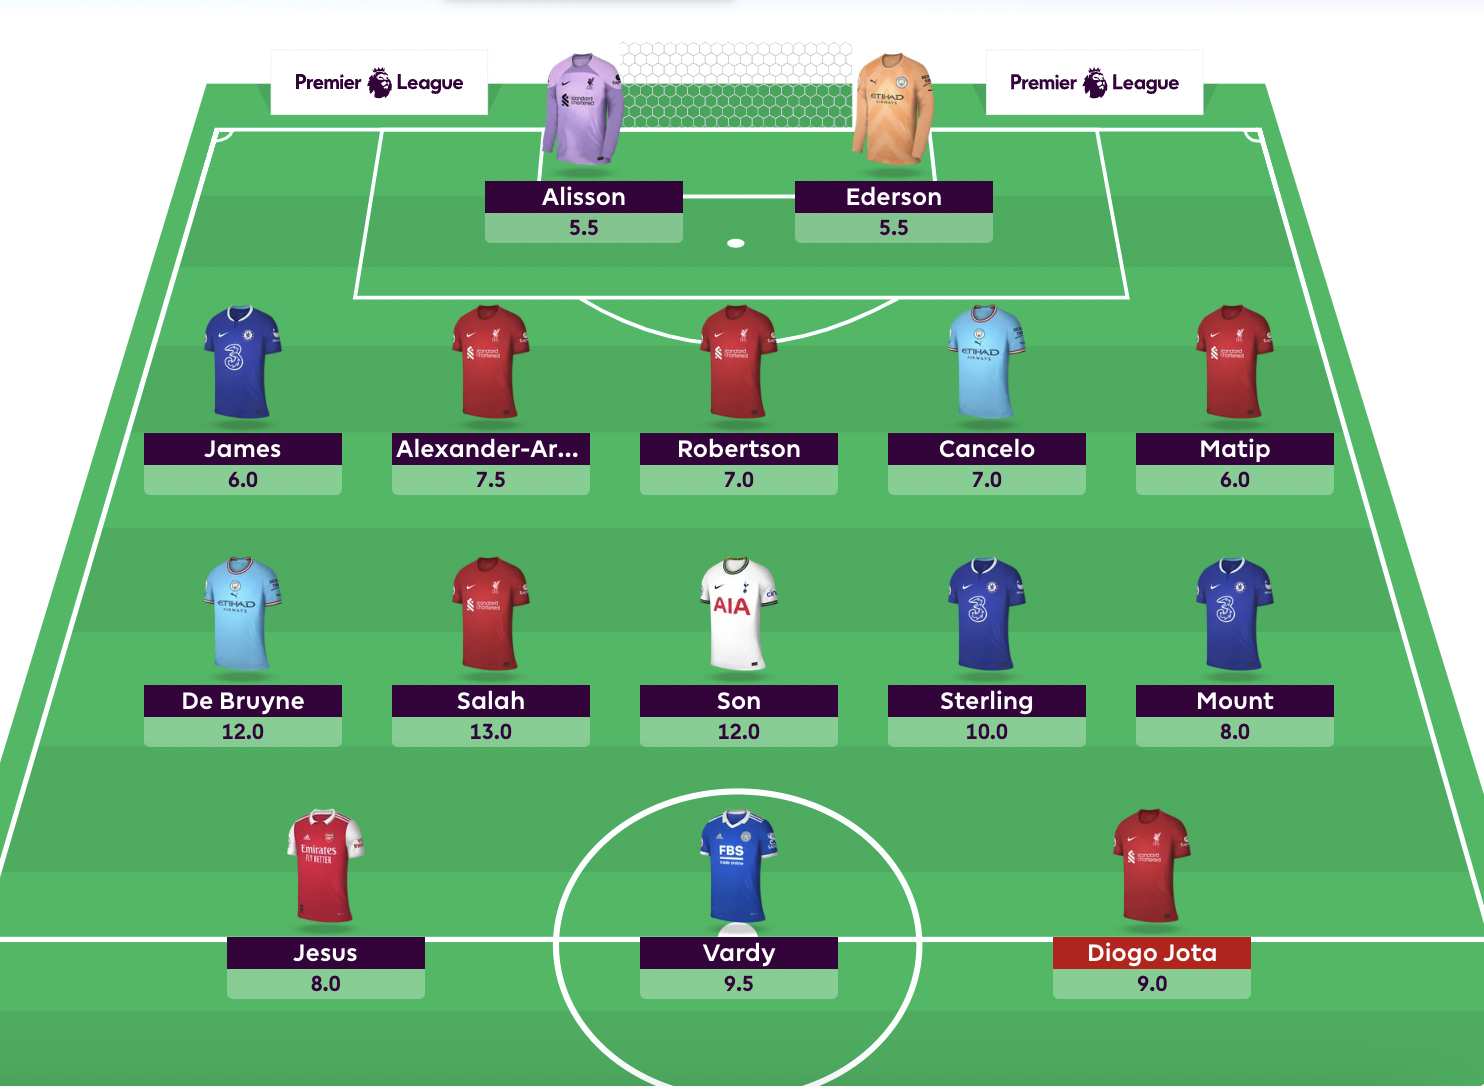

## Ideal Team - Total Points <a class="anchor" id="total-points-team"></a>

The algorithm below gives us an ideal team (the best player picks), according to **Total Points Scored**. The team fulfills the position requirements (2 goalkeepers, 5 defenders, 5 midfielders, and 3 forwards). 

If we were to freely pick players based on Total Points Scored last season (assuming no other manager picks any of these players - which is very unlikely), we should pick this team's players.

In [16]:
#Best Overall Team (Total Points)
ranked_total_points = draft_selection_stats.sort_values('total_points', ascending=False)
goalkeepers = []
defenders = []
midfielders = []
forwards = []
for index, row in ranked_total_points.iterrows():
    if row['position'] == 'GKP' and len(goalkeepers) < 2:
        goalkeepers.append(row['player'])
    elif row['position'] == 'DEF' and len(defenders) < 5:
        defenders.append(row['player'])
    elif row['position'] == 'MID' and len(midfielders) < 5:
        midfielders.append(row['player'])
    elif row['position'] == 'FWD' and len(forwards) < 3:
        forwards.append(row['player'])

print(goalkeepers)
print(defenders)
print(midfielders)
print(forwards)

['Alisson Ramses Becker', 'Ederson Santana de Moraes']
['Trent Alexander-Arnold', 'João Pedro Cavaco Cancelo', 'Virgil van Dijk', 'Andrew Robertson', 'Joel Matip']
['Mohamed Salah', 'Heung-Min Son', 'Jarrod Bowen', 'Kevin De Bruyne', 'Bukayo Saka']
['Harry Kane', 'Diogo Jota', 'Cristiano Ronaldo dos Santos Aveiro']


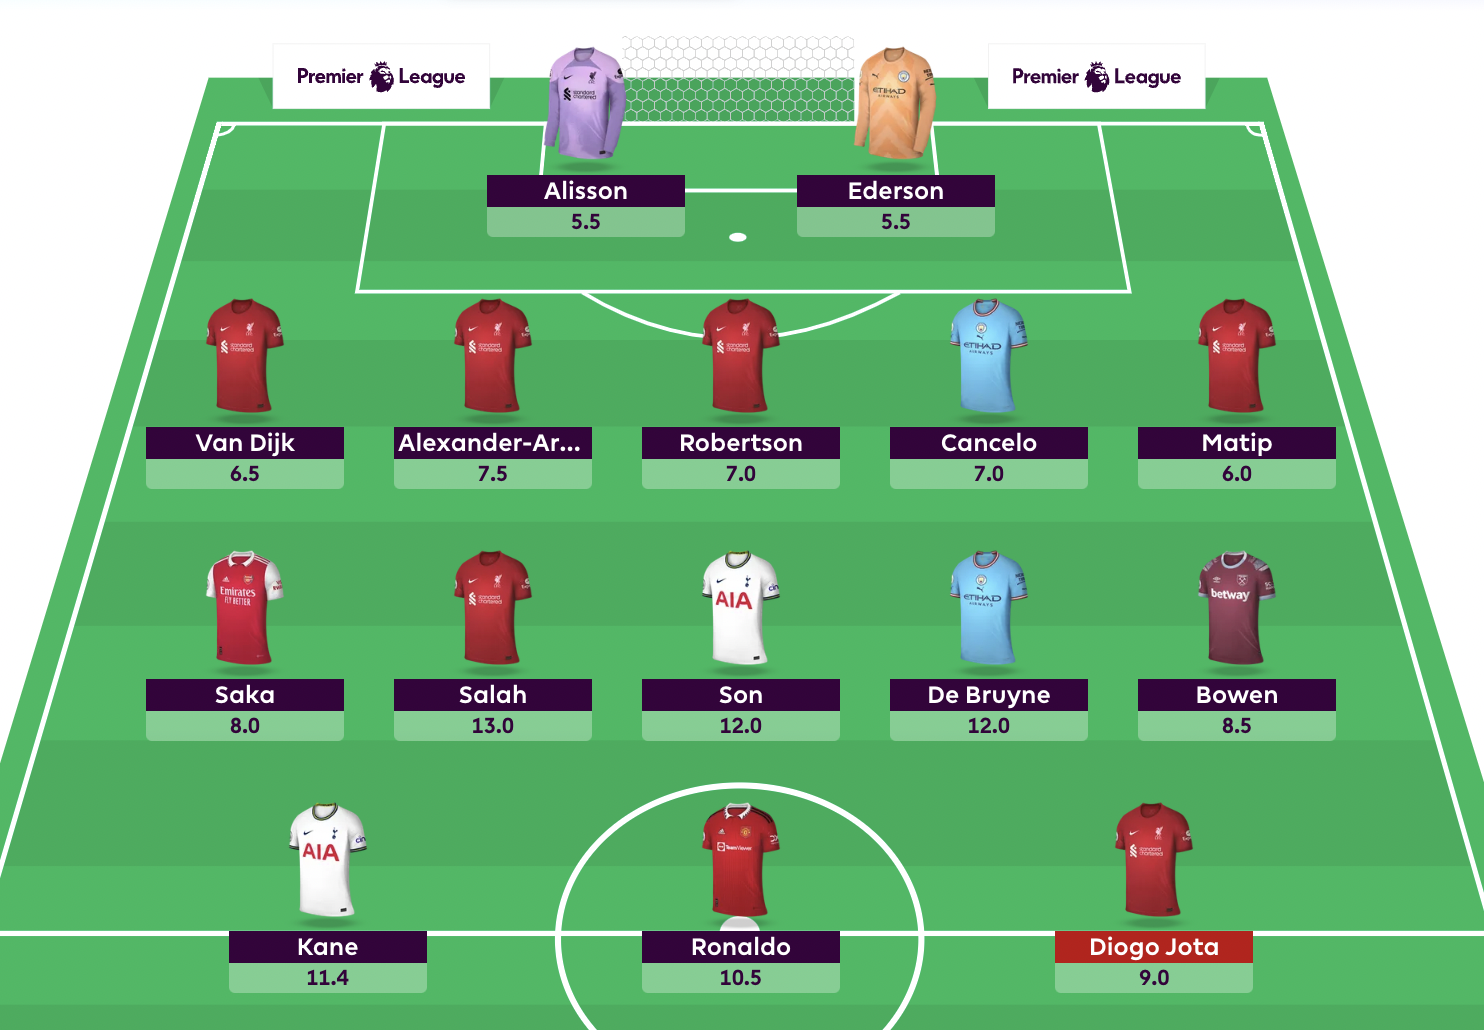

## Ideal Team - Injured/Rotating/Transferred Players <a class="anchor" id="injured-team"></a>

The algorithm below gives us an ideal team (the best player picks), for **Injured/Rotating/Transferred players**. The team fulfills the position requirements (2 goalkeepers, 5 defenders, 5 midfielders, and 3 forwards). 

In [17]:
#Best Overall Team (Injured)
goalkeepers = []
defenders = []
midfielders = []
forwards = []
for index, row in draft_selection_stats_injured.iterrows():
    if row['position'] == 'GKP' and len(goalkeepers) < 2:
        goalkeepers.append(row['player'])
    elif row['position'] == 'DEF' and len(defenders) < 5:
        defenders.append(row['player'])
    elif row['position'] == 'MID' and len(midfielders) < 5:
        midfielders.append(row['player'])
    elif row['position'] == 'FWD' and len(forwards) < 3:
        forwards.append(row['player'])

print(goalkeepers)
print(defenders)
print(midfielders)
print(forwards)

['Fraser Forster', 'Alex McCarthy']
['Trevoh Chalobah', 'Davinson Sánchez', 'Takehiro Tomiyasu', 'Tariq Lamptey', 'John Stones']
['Riyad Mahrez', 'Manuel Lanzini', 'Yoane Wissa', 'Dejan Kulusevski', 'Ryan Fraser']
['Odsonne Edouard', 'Kelechi Iheanacho', 'Danny Welbeck']


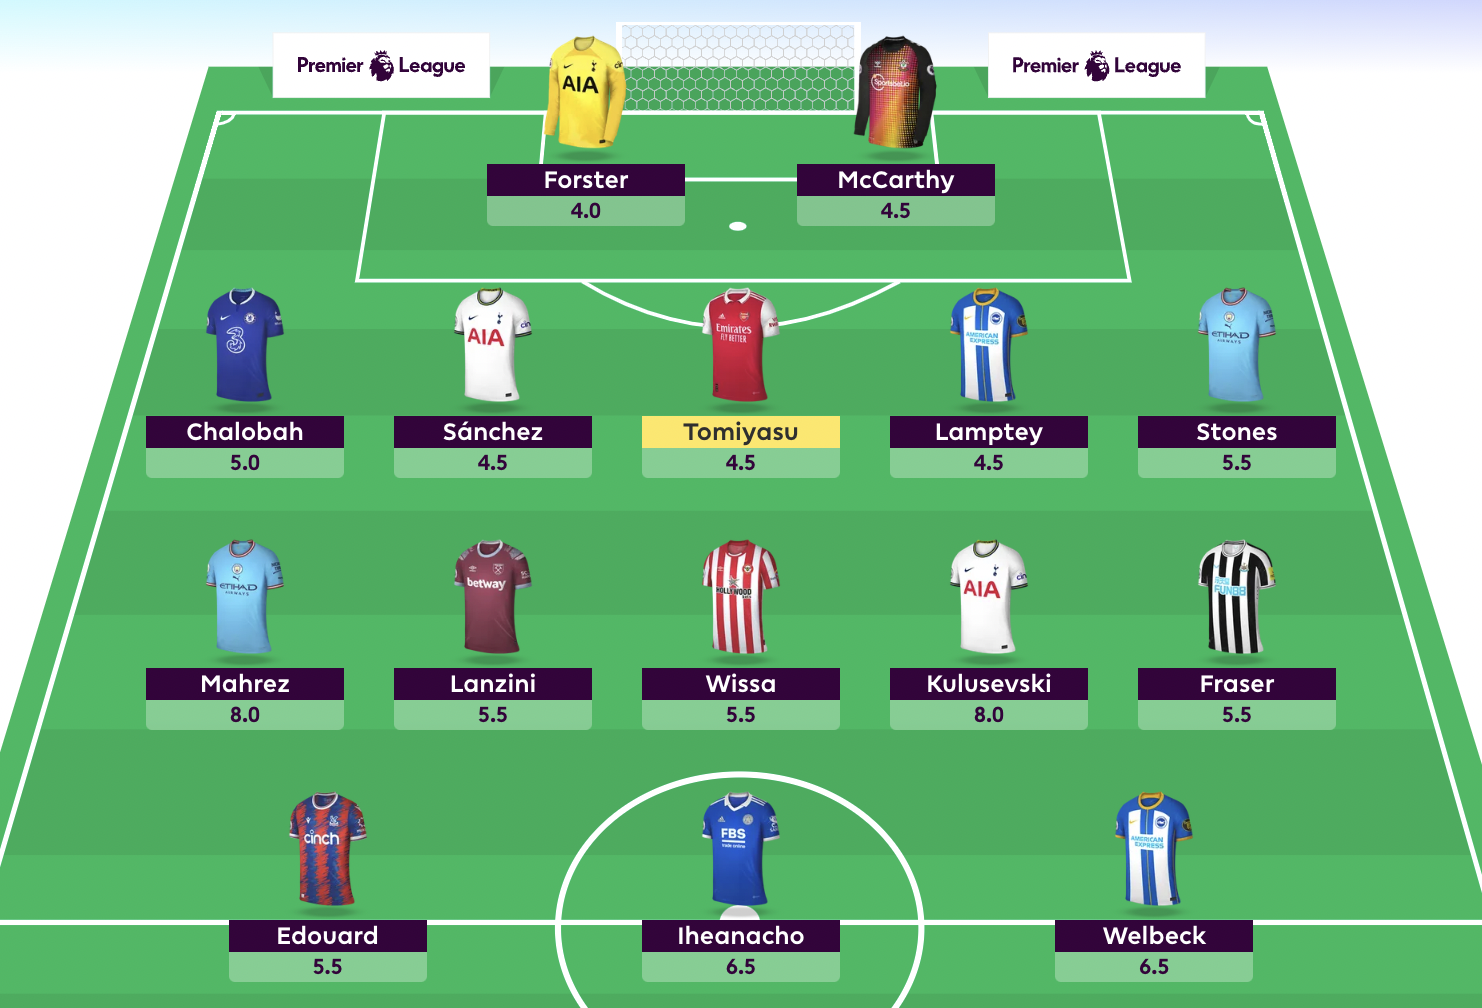

## Model Limitations <a class="anchor" id="limitations"></a>

While this model does help us optimize the player selection process for the FPL draft, it also has some limitations.

1. **Past Performance Is Not Indicative Of Future Results**: Although we are basing our player selections solely on last season's performance, it might not be indicative of this season's expected performance.

2. **Summer Transfers**: The model will not tell us the optimal pick round and number for a player who was recently transferred in to the premier league - as we do not have data for players who were transferred in during the summer transfer window. 

3. **Other Statistics**: Total Points and PP90min are not the only relevant statistics when it comes to selecting players. Other statistics (or a combination of various statistics) could also be good metrics to base your player selections on.